<a href="https://colab.research.google.com/github/davemlz/eemont/blob/master/tutorials/014-Time-Series-By-Regions-Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series By Regions (with Conversion to Pandas and Visualization with Seaborn) using EEMONT, GEETOOLS and GEEMAP

- GitHub Repo: [https://github.com/davemlz/eemont](https://github.com/davemlz/eemont)
- PyPI link: [https://pypi.org/project/eemont/](https://pypi.org/project/eemont/)
- Documentation: [https://eemont.readthedocs.io/en/0.1.8/index.html](https://eemont.readthedocs.io/en/0.1.8/index.html)
- More tutorials: [https://github.com/davemlz/eemont/tree/master/tutorials](https://github.com/davemlz/eemont/tree/master/tutorials)

## Let's start!

NOTE: before running this notebook, pass the following commands to a Python terminal. (File, New, Terminal)

Return to this notebook and Import the required packges.

In [35]:
import ee, eemont, geemap
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# import geetools for cloud /sadow discrimination
from geetools import ui, cloud_mask


Authenticate and Initialize Earth Engine and geemap.

In [36]:
Map = geemap.Map()
Map.add_basemap('Esri Satellite')
Map


Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

Let's use some center-pivot crops in Utah:

In [37]:
pivot0=ee.Geometry.Point([-113.663642,37.682951]).buffer(500) #the number in buffer is the radius for the center pivot
pivot1=ee.Geometry.Point([-113.698426,37.623206]).buffer(400)
pivot2=ee.Geometry.Point([-113.642373,37.732786]).buffer(400)

Map.addLayer(pivot0,{},'pivot0')
Map.addLayer(pivot1,{},'pivot1')
Map.addLayer(pivot2,{},'pivot2')

Map.centerObject(pivot0,12)


Let's combine the different center pivot features into a Feature Collection

In [38]:
pivots = ee.FeatureCollection([
    ee.Feature(pivot0,{'pivot':0}),
    ee.Feature(pivot1,{'pivot':1}),
    ee.Feature(pivot2,{'pivot':2})    
])

Let's pre-process and process our image collection; LANDSAT 8

In [39]:
L8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(pivots)


In [40]:
# CLOUD MASKING IN EE PYTHON NOT QUITE EASY. USING THE GEETOOLS custom functions https://github.com/gee-community/gee_tools 

# this function only for Landsat 8 Surface Corrected single image
mask_l8SR_all = cloud_mask.landsatSR() #this function masks clouds, snow, shadows

# mask_l8SR_cloud = cloud_mask.landsatSR(['cloud'])
# mask_l8SR_shadow = cloud_mask.landsatSR(['shadow'])
# mask_l8SR_snow = cloud_mask.landsatSR(['snow'])

In [41]:
# creating a function for masking the entire ImmageCollection
def maskL8sr(image):
    cld_free=mask_l8SR_all(image)
    return cld_free

NOTE check eemont repository for examples of maskCLouds, scale, and application of vegetation indexes. https://eemont.readthedocs.io/en/latest/guide/spectralIndices.html

In [42]:
L8 = L8.map(maskL8sr).scale().index(['kNDVI','NDVI','SAVI'])

Let's check which bands are available.

In [43]:
L8.first().bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B10',
 'B11',
 'sr_aerosol',
 'pixel_qa',
 'radsat_qa',
 'kNDVI',
 'NDVI',
 'SAVI']

## Time Lapse of the Satellite data

Using Geemap example 72

In [44]:
collection = L8.select("NDVI").filter(ee.Filter.date('2019-04-01', '2019-12-01')).sort('system:time_start')

vis_params = {
  'min': 0.0,
  'max': 1.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
}

first_image = collection.first()

Map.addLayer(first_image, vis_params, "First image")
# Map.setCenter(-7.03125, 31.0529339857, 2)
Map

Map(center=[37.68295151294841, -113.66364198203783], controls=(WidgetControl(options=['position'], widget=HBox…

In [45]:
# image = collection.toBands()
# Map.addLayer(image, {}, "Time series", False)

In [46]:
labels = collection.aggregate_array("system:index").getInfo()
Map.add_time_slider(collection, vis_params, labels=labels, time_interval=1)

## Time Series By Regions

Let's get the L8 time series for our buffer. Checklist:

- Image Collection: The Landsat 8 collection.
- Bands to use for the time series: GNDVI and EVI.
- Feature Collection: Our center-pivot crops.
- Statistics to compute: Mean and Median.
- Scale: 30 m.

In [47]:
ts = L8.getTimeSeriesByRegions(collection = pivots,
                               bands = ['kNDVI','NDVI','SAVI'],
                               reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                               scale = 30)

## Conversion to Pandas

The time series is retrieved as a feature collection. To convert it to a pandas dataframe we'll use `geemap` (This may take a little bit):

In [48]:
tsPandas = geemap.ee_to_pandas(ts)

Let's check our pandas data frame:

In [49]:
tsPandas

,NDVI,SAVI,date,kNDVI,pivot,reducer
0,0.137762,0.098314,2013-03-29T18:11:42,0.019028,0,mean
1,0.343453,0.207647,2013-03-29T18:11:42,0.118387,1,mean
2,0.313492,0.213478,2013-03-29T18:11:42,0.098951,2,mean
3,0.141594,0.105059,2013-04-22T18:10:46,0.020104,0,mean
4,0.727673,0.479611,2013-04-22T18:10:46,0.485032,1,mean
...,...,...,...,...,...,...
2095,0.186099,0.110775,2021-03-02T18:15:09,0.034621,1,median
2096,0.172087,0.114957,2021-03-02T18:15:09,0.029662,2,median
2097,0.458421,0.209378,2021-03-18T18:14:59,0.206508,0,median
2098,-9999.000000,-9999.000000,2021-03-18T18:14:59,-9999.000000,1,median


What can we see here?

- The values for each band (GNDVI and EVI) are in separated columns.
- There are some -9999 values in the GNDVI and EVI columns. These values represent the NA values (e.g. Clouds or shadows). The -9999 can be changed by modifying the `naValue` parameter in the `getTimeSeriesByRegion` method (e.g. `naValue = -10000`).
- Multiple reducers can be used. In the output dataframe they are specified by a single column named `reducer`: mean, median.
- The date is a string that needs to be converted to a date data type.
- The attributes of the original feature collection are attached to the data frame: `pivot`.

Given this, let's curate our data frame!

First, let's get rid of the -9999 value:

In [50]:
tsPandas[tsPandas == -9999] = np.nan

And now, let's convert the date to a date data type:

In [51]:
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)

We can also gather the GNDVI and EVI columns into a single column to make the data frame more 'tidy-er' (This is optional):

In [52]:
tsPandas = pd.melt(tsPandas,
                   id_vars = ['reducer','date','pivot'],
                   value_vars = ['NDVI','kNDVI','SAVI'],
                   var_name = 'Index',
                   value_name = 'Value')

Let's check our curated data frame:

In [53]:
# tsPandas[tsPandas['Value'] > 1] = np.nan
tsPandas[tsPandas['Value'] < 0] = np.nan

tsPandas

,reducer,date,pivot,Index,Value
0,mean,2013-03-29 18:11:42,0.0,NDVI,0.137762
1,mean,2013-03-29 18:11:42,1.0,NDVI,0.343453
2,mean,2013-03-29 18:11:42,2.0,NDVI,0.313492
3,mean,2013-04-22 18:10:46,0.0,NDVI,0.141594
4,mean,2013-04-22 18:10:46,1.0,NDVI,0.727673
...,...,...,...,...,...
6295,median,2021-03-02 18:15:09,1.0,SAVI,0.110775
6296,median,2021-03-02 18:15:09,2.0,SAVI,0.114957
6297,median,2021-03-18 18:14:59,0.0,SAVI,0.209378
6298,median,2021-03-18 18:14:59,1.0,SAVI,NaN


## Visualization

Now, let's visualize our time series using `seaborn`:

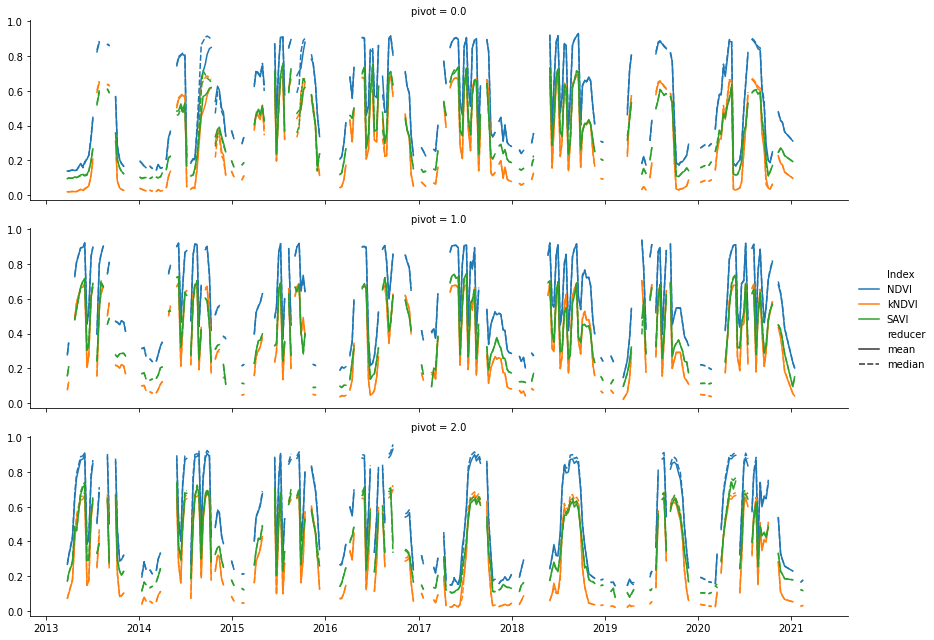

In [54]:
g = sns.FacetGrid(tsPandas,row = 'pivot',height = 3,aspect = 4)
g.map_dataframe(sns.lineplot,x = 'date',y = 'Value',hue = 'Index',style = 'reducer')
g.add_legend()

Let's do the same, but now for radiometric temperature (two bands, B10 and B11).

In [55]:
ts = L8.getTimeSeriesByRegions(collection = pivots,
                               bands = ['B10','B11'],
                               reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                               scale = 30)

In [56]:
tsPandas2 = geemap.ee_to_pandas(ts)

In [57]:
tsPandas2

,B10,B11,date,pivot,reducer
0,306.408830,303.825634,2013-03-29T18:11:42,0,mean
1,303.716339,301.123406,2013-03-29T18:11:42,1,mean
2,303.921917,301.420303,2013-03-29T18:11:42,2,mean
3,307.296102,305.459169,2013-04-22T18:10:46,0,mean
4,297.388625,296.231587,2013-04-22T18:10:46,1,mean
...,...,...,...,...,...
2095,289.500000,288.000000,2021-03-02T18:15:09,1,median
2096,293.400000,292.400000,2021-03-02T18:15:09,2,median
2097,284.700000,283.500000,2021-03-18T18:14:59,0,median
2098,-9999.000000,-9999.000000,2021-03-18T18:14:59,1,median


In [58]:
tsPandas2[tsPandas2 == -9999] = np.nan

tsPandas2['date'] = pd.to_datetime(tsPandas2['date'],infer_datetime_format = True)

In [59]:
tsPandas2 = pd.melt(tsPandas2,
                   id_vars = ['reducer','date','pivot'],
                   value_vars = ['B10','B11'],
                   var_name = 'Index',
                   value_name = 'Value')

In [60]:
tsPandas2

,reducer,date,pivot,Index,Value
0,mean,2013-03-29 18:11:42,0,B10,306.408830
1,mean,2013-03-29 18:11:42,1,B10,303.716339
2,mean,2013-03-29 18:11:42,2,B10,303.921917
3,mean,2013-04-22 18:10:46,0,B10,307.296102
4,mean,2013-04-22 18:10:46,1,B10,297.388625
...,...,...,...,...,...
4195,median,2021-03-02 18:15:09,1,B11,288.000000
4196,median,2021-03-02 18:15:09,2,B11,292.400000
4197,median,2021-03-18 18:14:59,0,B11,283.500000
4198,median,2021-03-18 18:14:59,1,B11,NaN


Visualization

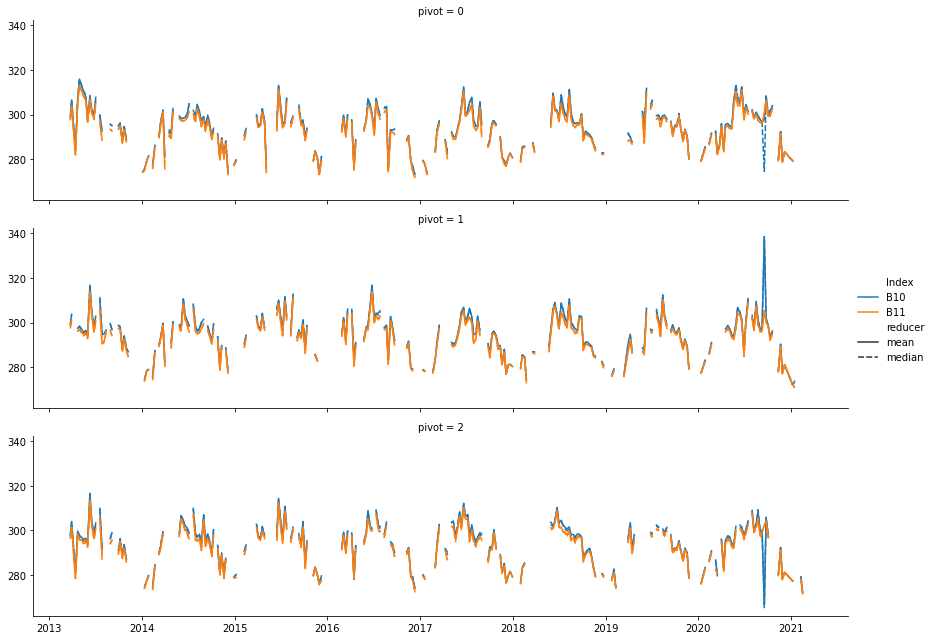

In [61]:
g = sns.FacetGrid(tsPandas2,row = 'pivot',height = 3,aspect = 4)
g.map_dataframe(sns.lineplot,x = 'date',y = 'Value',hue = 'Index',style = 'reducer')
g.add_legend()

Is there any relationship between NDVI and temperature?

In [66]:
dfinal = tsPandas.merge(tsPandas2, on=['date','reducer','pivot'])
dfinal

,reducer,date,pivot,Index_x,Value_x,Index_y,Value_y
0,mean,2013-03-29 18:11:42,0.0,NDVI,0.137762,B10,306.408830
1,mean,2013-03-29 18:11:42,0.0,NDVI,0.137762,B11,303.825634
2,mean,2013-03-29 18:11:42,0.0,kNDVI,0.019028,B10,306.408830
3,mean,2013-03-29 18:11:42,0.0,kNDVI,0.019028,B11,303.825634
4,mean,2013-03-29 18:11:42,0.0,SAVI,0.098314,B10,306.408830
...,...,...,...,...,...,...,...
12595,median,2021-03-18 18:14:59,2.0,NDVI,0.171475,B11,288.700000
12596,median,2021-03-18 18:14:59,2.0,kNDVI,0.029464,B10,291.700000
12597,median,2021-03-18 18:14:59,2.0,kNDVI,0.029464,B11,288.700000
12598,median,2021-03-18 18:14:59,2.0,SAVI,0.116917,B10,291.700000


In [85]:
select_color = dfinal.loc[(dfinal['Index_x'] == 'NDVI') & (dfinal['Index_y'] == 'B10') & (dfinal['pivot'] == 0)& (dfinal['reducer'] == 'mean')]
select_color

,reducer,date,pivot,Index_x,Value_x,Index_y,Value_y
0,mean,2013-03-29 18:11:42,0.0,NDVI,0.137762,B10,306.408830
18,mean,2013-04-22 18:10:46,0.0,NDVI,0.141594,B10,307.296102
36,mean,2013-05-24 18:11:02,0.0,NDVI,0.164506,B10,307.978358
54,mean,2013-06-09 18:11:00,0.0,NDVI,0.207524,B10,308.635887
72,mean,2013-06-25 18:10:56,0.0,NDVI,0.324716,B10,299.764536
...,...,...,...,...,...,...,...
6210,mean,2020-11-26 18:15:30,0.0,NDVI,0.419303,B10,279.076437
6228,mean,2021-01-13 18:15:21,0.0,NDVI,NaN,B10,NaN
6246,mean,2021-02-14 18:15:15,0.0,NDVI,0.314607,B10,271.787354
6264,mean,2021-03-02 18:15:09,0.0,NDVI,0.327733,B10,286.484115


<AxesSubplot:title={'center':'Center Pivot 0'}, xlabel='Value_y', ylabel='Value_x'>

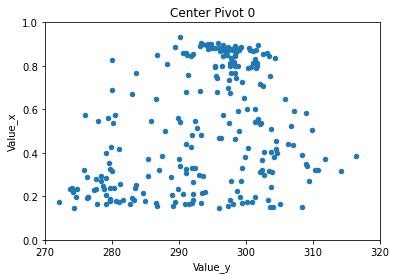

In [95]:
select_color.plot(kind='scatter',x="Value_y",y="Value_x",title="Center Pivot 0",xlim=(270,320),ylim=(0,1))

<AxesSubplot:title={'center':'Center Pivot 1'}, xlabel='Value_y', ylabel='Value_x'>

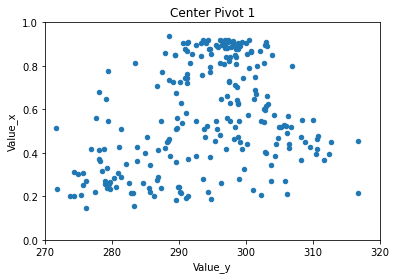

In [96]:
select_color = dfinal.loc[(dfinal['Index_x'] == 'NDVI') & (dfinal['Index_y'] == 'B10') & (dfinal['pivot'] == 1)& (dfinal['reducer'] == 'mean')]
select_color.plot(kind='scatter',x="Value_y",y="Value_x",title="Center Pivot 1",xlim=(270,320),ylim=(0,1))

<AxesSubplot:title={'center':'Center Pivot 2'}, xlabel='Value_y', ylabel='Value_x'>

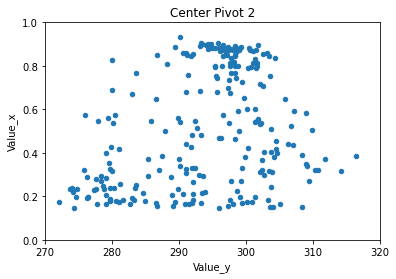

In [98]:
select_color = dfinal.loc[(dfinal['Index_x'] == 'NDVI') & (dfinal['Index_y'] == 'B10') & (dfinal['pivot'] == 2)& (dfinal['reducer'] == 'mean')]
select_color.plot(kind='scatter',x="Value_y",y="Value_x",title="Center Pivot 2",xlim=(270,320),ylim=(0,1),xlabel='B10',ylabel='NDVI')

## Assignment:
    
Create two notebooks, and in each notebook, change the center pivot locations, for the first one, select 3 center pivots around "El Amal, Markaz Abo El Matamier, Beheira" (Egypt) and the second notebook select 3 center pivots around  "Seminole, Texas". Please, discuss the time series variability in vegetation indices and temperatures between the two notebooks. What could be reasons for the found differences?

Happy Coding!
